# MobileCLIP2 + CoOp (Context Optimization)

This notebook starts from **MobileCLIP2** via `open_clip_torch` and adds a simple **Context Optimization (CoOp)** prompt learner, following the project's **STYLEGUIDE**.

**Notebook flow** (from STYLEGUIDE):
1. `!pip install` (only if needed)
2. Common imports + seeds
3. Load the model / pretrained model (+ preprocessors / related utilities)
4. Create own model module with clear separation of base vs add-ons
5. Hyperparameters section
6. Optimizer + Schedule
7. Train
8. Plot History
9. Evaluate + Show final result
10. Extra analysis and visualisation

> **References**: MobileCLIP2 in OpenCLIP (`MobileCLIP2-S{0,2,3,4}, B, L-14` with `pretrained='dfndr2b'`) and CoOp (Zhou et al.).


In [4]:
!pip install torchinfo open_clip_torch --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.2 MB/s eta 0:00:00


In [5]:
# 1) (Optional) Installs — uncomment on first run
# !pip install -U matplotlib timm torchvision torch tqdm scikit-learn --quiet
# !pip install -U open-clip-torch torchinfo --quiet
print('If you need packages, uncomment the pip lines above and run this cell.')

If you need packages, uncomment the pip lines above and run this cell.


In [6]:
# 2) Common imports + seeds
import math, random, os, time
from dataclasses import dataclass
from typing import Tuple, List

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset

import torchvision
from torchvision import datasets, transforms

import torchinfo

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import open_clip

def set_seed(seed:int=42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(123)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
import pathlib
p = pathlib.Path(open_clip.__file__).parent
print(p)

/usr/local/lib/python3.12/dist-packages/open_clip


In [8]:
from dataclasses import dataclass
from typing import Tuple

# Pick a lightweight variant for quick experiments
MODEL_NAME = 'MobileCLIP2-S0'   # alternatives: 'MobileCLIP2-S2', 'MobileCLIP2-B', 'MobileCLIP2-S3', 'MobileCLIP2-S4', 'MobileCLIP2-L-14'
PRETRAINED = 'dfndr2b'          # per MobileCLIP2 release in OpenCLIP


@dataclass
class Config:
    model_name: str = "MobileCLIP2-S0"  # new MobileCLIP2 in open_clip
    pretrained: str = "dfndr2b"
    image_size: int = 224
    batch_size: int = 64
    num_workers: int = 4
    max_epochs: int = 5

    # LR split: base vs prompt
    lr_base: float = 1e-5
    lr_prompt: float = 1e-3
    weight_decay: float = 0.05

    # Unfreeze (if you want a light finetune on top of prompt)
    unfreeze_layers: Tuple[str, ...] = tuple()  # e.g. ("visual.transformer.resblocks.11",)

    # CoOp prompt length
    prompt_len: int = 4

    # Overfit sanity tiny subset
    overfit_n_classes: int = 2
    overfit_k_per_class: int = 8
    overfit_epochs: int = 50

cfg = Config()
cfg


Config(model_name='MobileCLIP2-S0', pretrained='dfndr2b', image_size=224, batch_size=64, num_workers=4, max_epochs=5, lr_base=1e-05, lr_prompt=0.001, weight_decay=0.05, unfreeze_layers=(), prompt_len=4, overfit_n_classes=2, overfit_k_per_class=8, overfit_epochs=50)

In [9]:
# open_clip provides: model, preprocess
model, train_preprocess, val_preprocess = open_clip.create_model_and_transforms(
    cfg.model_name, pretrained=cfg.pretrained, device=device
)
tokenizer = open_clip.get_tokenizer(cfg.model_name)

torchinfo.summary(model)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


open_clip_model.safetensors:   0%|          | 0.00/300M [00:00<?, ?B/s]

Layer (type:depth-idx)                                                           Param #
CustomTextCLIP                                                                   1
├─TimmModel: 1-1                                                                 --
│    └─FastVit: 2-1                                                              --
│    │    └─Sequential: 3-1                                                      7,424
│    │    └─Sequential: 3-2                                                      10,728,256
│    │    └─MobileOneBlock: 3-3                                                  146,496
│    │    └─ClassifierHead: 3-4                                                  524,800
│    └─Sequential: 2-2                                                           --
├─TextTransformer: 1-2                                                           301,568
│    └─Embedding: 2-3                                                            25,296,896
│    └─Transformer: 2-4               

In [10]:
model

CustomTextCLIP(
  (visual): TimmModel(
    (trunk): FastVit(
      (stem): Sequential(
        (0): MobileOneBlock(
          (se): Identity()
          (conv_kxk): ModuleList(
            (0): ConvNormAct(
              (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
              (bn): BatchNormAct2d(
                64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
                (drop): Identity()
                (act): Identity()
              )
            )
          )
          (conv_scale): ConvNormAct(
            (conv): Conv2d(3, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
            (bn): BatchNormAct2d(
              64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Identity()
            )
          )
          (act): GELU(approximate='none')
        )
        (1): MobileOneBlock(
          (se): Identity()
          (conv_kxk): ModuleList

In [11]:
print(model.text.pool_type)

argmax


100%|██████████| 170M/170M [00:04<00:00, 40.7MB/s]


Train dataset: 50000 images, 10 classes
Val dataset:   10000 images, 10 classes


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


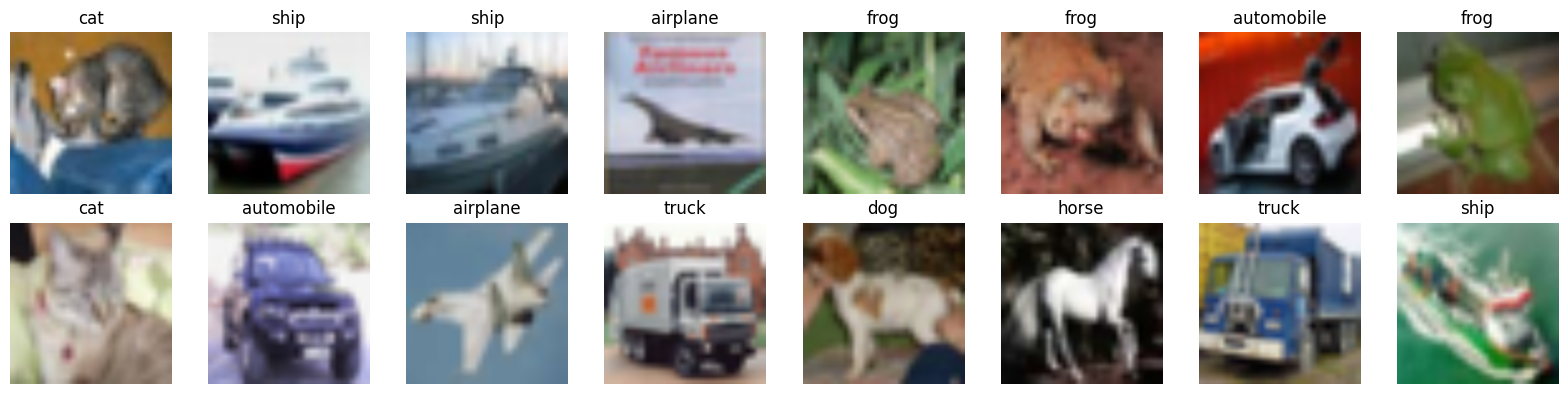

In [12]:
train_ds = datasets.CIFAR10(root="data", train=True,  transform=train_preprocess, download=True)
val_ds   = datasets.CIFAR10(root="data", train=False, transform=val_preprocess,  download=True)
classnames = train_ds.classes  # list[str]
# instead of using the tfm, just use the preprocess from open_clip
num_classes = len(classnames)

train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True,
                          num_workers=cfg.num_workers, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=cfg.batch_size, shuffle=False,
                          num_workers=cfg.num_workers, pin_memory=True)


print(f"Train dataset: {len(train_ds)} images, {num_classes} classes")
print(f"Val dataset:   {len(val_ds)} images, {num_classes} classes")

# Print few samples from test set
# Make utility to print a line of images with labels

def show_batch(dl: DataLoader, rows: int=2, cols: int=8):
    batch = next(iter(dl))
    images, labels = batch
    fig, axs = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    for i in range(rows):
        for j in range(cols):
            idx = i*cols + j
            if idx >= len(images):
                break
            img = images[idx].permute(1, 2, 0).cpu().numpy()
            label = classnames[labels[idx]]
            axs[i, j].imshow(img)
            axs[i, j].set_title(label)
            axs[i, j].axis('off')
    plt.tight_layout()
    plt.show()

show_batch(val_loader, rows=2, cols=8)

## 4) Model module: base (frozen MobileCLIP2) + CoOp prompt learner

- We keep the CLIP backbone **frozen** and in **eval** mode (BatchNorm stability on MobileCLIP2).
- We learn **M** context vectors `ctx` ("soft words") that prepend the class name tokens.
- Shapes are annotated per STYLEGUIDE.

In [13]:
class HardcodedPrompt(nn.Module):
    def __init__(self, model, classnames: List[str]):
        super().__init__()
        self.text_tower = model.text

        self.prompts = [f"a photo of a {c}" for c in classnames]
        self.tokenized = tokenizer(self.prompts).to(device)
        self.text_features = self.text_tower(self.tokenized)

    def forward(self):
        return self.text_features

In [ ]:
class ZeroShotClassifier(nn.Module):
    def __init__(self, model, classnames: List[str]):
        super().__init__()
        self.base_model = model
        self.image_tower = model.visual
        self.hardcoded_prompt = HardcodedPrompt(model, classnames)

    def forward(self, image):
        image_features = self.image_tower.encode_image(image)
        text_features  = self.hardcoded_prompt()
        logit_scale = self.base_model.logit_scale.exp()
        logits = logit_scale * image_features @ text_features.t()
        return logits

In [15]:
#model_zeroshot = ZeroShotClassifier(model, classnames).to(device)

In [ ]:
class CoOpPrompt(nn.Module):
    def __init__(self, model, tokenizer, classnames: List[str], prompt_len: int):
        super().__init__()
        self.text_tower = model.text
        self.tokenizer = tokenizer
        self.classnames = classnames
        self.prompt_len = prompt_len
        self.num_classes = len(classnames)

        self.max_prompt_len = self.text_tower.positional_embedding.size(0) # Should be 77

        self.register_buffer("sot_id", torch.tensor(tokenizer.sot_token_id, dtype=torch.long))
        self.register_buffer("eot_id", torch.tensor(tokenizer.eot_token_id, dtype=torch.long))
        self.register_buffer("pad_id", torch.tensor(0, dtype=torch.long))

        #self.sot = self.text_tower.token_embedding(torch.tensor(tokenizer.sot_token_id))
        #self.eot = self.text_tower.token_embedding(torch.tensor(tokenizer.eot_token_id))
        #self.pad = self.text_tower.token_embedding(torch.tensor(0))

        # Initialize the prompt tokens as learnable parameters
        # Only one prompt shared across all classes (prevents overfitting)
        # Shape: (prompt_len, embedding_dim)
        self.prompt_embeddings = nn.Parameter(
            0.02 * torch.randn(prompt_len, model.text.token_embedding.embedding_dim)
        )
        # TODO: better init, e.g. from "a photo of a:"

        # Precompute class name embeddings (not learnable)
        # This works because token_embedding is frozen
        self.register_buffer("class_token_ids", torch.tensor([self.tokenizer.encode(f"{c}") for c in classnames], dtype=torch.long))
        #self.class_token_ids = nn.ParameterList(
        #    [nn.Parameter(torch.tensor(self.tokenizer.encode(f"{c}"), device=device, dtype=torch.long), requires_grad=False)
        #     for c in classnames]
        #)
        #for c in classnames:
        #    cls_ids = torch.tensor(self.tokenizer.encode(f"{c}"), device=device, dtype=torch.long)
        #    cls_emb = self.text_tower.token_embedding(cls_ids)  # (len_c, D)
        #    self.class_embeddings.append(cls_emb)


    def forward(self):
        # Create the full tokenized prompts with learnable tokens
        sot = self.text_tower.token_embedding(self.sot_id).unsqueeze(0)  # (1, D)
        eot = self.text_tower.token_embedding(self.eot_id).unsqueeze(0)  # (1, D)
        pad = self.text_tower.token_embedding(self.pad_id).unsqueeze(0)  # (1, D)

        emb_rows = []
        eot_indices = []
        for ids in self.class_token_ids:
            cls_emb = self.text_tower.token_embedding(ids)  # (len_c, D)

            needed_pad = self.max_prompt_len - cls_emb.size(0) - 2 - self.prompt_len
            pad_embs = pad.expand(needed_pad, -1)  # (needed_pad, D)
            row = torch.cat([sot, self.prompt_embeddings, cls_emb, eot, pad_embs], dim=0)  # (len_c + needed_pad, D)
            emb_rows.append(row)

            eot_idx = row.size(0) - needed_pad - 1  # Index of the eot token in this row
            eot_indices.append(eot_idx)

        full_prompt_embeddings = torch.stack(emb_rows, dim=0)

        # Pass through the rest of the text tower
        x = full_prompt_embeddings + self.text_tower.positional_embedding.unsqeeze(0)  # Shape: (num_classes, seq_len, embedding_dim)
        x = x.permute(1, 0, 2)  # Shape: (seq_len, num_classes, embedding_dim)
        x = self.text_tower.transformer(x)
        x = x.permute(1, 0, 2)  # Shape: (num_classes, seq_len, embedding_dim)
        x = self.text_tower.ln_final(x)

        eot_idx = torch.tensor(eot_indices, device=x.device)
        # or
        # eot_idx =
        # Because pool_type is 'argmax', that being the eot token
        x = x[torch.arange(x.size(0)), eot_idx, :] # (num_classes, embedding_dim)

        # Make the final projection
        text_features = x @ self.text_tower.text_projection # (N, D)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        return text_features

In [ ]:
class CoOpClassifier(nn.Module):
    def __init__(self, model, tokenizer, classnames: List[str], prompt_len):
        super().__init__()
        self.base_model = model
        self.image_tower = model.visual
        self.coop_prompt = CoOpPrompt(model, tokenizer, classnames, prompt_len=prompt_len)

    def forward(self, image):
        image_features = self.image_tower.encode_image(image)
        text_features  = self.coop_prompt()
        logit_scale = self.base_model.logit_scale.exp()
        logits = logit_scale * image_features @ text_features.t()
        return logits

In [30]:
model_coop = CoOpClassifier(model, tokenizer, classnames, prompt_len=cfg.prompt_len).to(device)

In [31]:
def evaluate(model, loader, device, loss_fn, desc="eval", pbar=True):
    model.eval()
    loss_sum, correct, count = 0.0, 0, 0
    iterator = tqdm(loader, desc=desc, leave=False) if pbar else loader

    with torch.no_grad():
        for data, target in iterator:
            data = data.to(device, non_blocking=True)
            target = target.to(device, non_blocking=True)
            output = model(data)
            loss = loss_fn(output, target)
            bs = data.size(0)
            loss_sum += loss.item() * bs
            preds = output.argmax(dim=1)
            correct += (preds == target).sum().item()
            count += bs
            if pbar:
                acc = (correct / max(1, count)) * 100.0
                iterator.set_postfix(loss=f"{loss.item():.4f}", acc=f"{acc:.2f}%")

    return loss_sum / max(1, count), correct / max(1, count)

In [32]:
def train(model, train_loader, val_loader, optimizer, device, epochs: int,
          log_interval: int = 25, ema_alpha: float = 0.1):
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    model.to(device)
    loss_fn = nn.CrossEntropyLoss()

    for epoch in range(1, epochs + 1):
        model.train()
        train_sum, train_correct, train_count = 0.0, 0, 0
        ema = None
        iterator = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} | train", leave=False, dynamic_ncols=True, mininterval=0.5)
        for step, (data, target) in enumerate(iterator, start=1):
            data = data.to(device, non_blocking=True)
            target = target.to(device, non_blocking=True)
            optimizer.zero_grad(set_to_none=True)
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()

            # --- DEBUG: grad norms ---
            with torch.no_grad():
                gnorm_ctx = 0.0
                for p in model.coop_prompt.parameters():
                    if p.grad is not None:
                        g = p.grad.detach()
                        gnorm_ctx += (g*g).sum().item()
                gnorm_ctx = math.sqrt(gnorm_ctx) if gnorm_ctx > 0 else 0.0
                if step % log_interval == 0:
                    tqdm.write(f"[dbg] ctx grad L2 = {gnorm_ctx:.6e}")

            optimizer.step()

            # stats
            bs = data.size(0)
            train_sum += (loss.item() * bs)
            preds = output.argmax(dim=1)
            train_correct += (preds == target).sum().item()
            train_count += bs
            ema = loss.item() if ema is None else (1 - ema_alpha) * ema + ema_alpha * loss.item()
            if (step % log_interval == 0) or (step == len(iterator)):
                acc_pct = 100.0 * train_correct / max(1, train_count)
                iterator.set_postfix_str(f"loss(ema)={ema:.4f} acc={acc_pct:.2f}%")

        avg_train_loss = train_sum / max(1, train_count)
        avg_train_acc  = train_correct / max(1, train_count)
        avg_val_loss, avg_val_acc = evaluate(model, val_loader, device, loss_fn=loss_fn, desc="valid", pbar=True)

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_acc'].append(avg_train_acc)
        history['val_acc'].append(avg_val_acc)

        tqdm.write(f"Epoch {epoch:03d}: train_loss={avg_train_loss:.4f} train_acc={avg_train_acc*100:.2f}%  "
                   f"val_loss={avg_val_loss:.4f} val_acc={avg_val_acc*100:.2f}%")

    return history

In [ ]:
for p in model_coop.base_model.parameters():
    p.requires_grad = False

model_coop.base_model.eval()
model_coop.train()

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_coop.coop_prompt.parameters(), lr=cfg.lr_prompt)
train(model_coop, train_loader, val_loader, optimizer, device, epochs=1, log_interval=10)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1/1 | train:   0%|          | 0/782 [00:00<?, ?it/s]

[dbg] ctx grad L2 = 1.827972e-06
[dbg] ctx grad L2 = 1.960119e-06
[dbg] ctx grad L2 = 1.779714e-06
[dbg] ctx grad L2 = 1.999398e-06
[dbg] ctx grad L2 = 1.749519e-06
[dbg] ctx grad L2 = 1.671350e-06
[dbg] ctx grad L2 = 1.663893e-06
[dbg] ctx grad L2 = 1.844587e-06
[dbg] ctx grad L2 = 1.748770e-06
[dbg] ctx grad L2 = 1.685191e-06
[dbg] ctx grad L2 = 1.526525e-06
[dbg] ctx grad L2 = 1.516819e-06
[dbg] ctx grad L2 = 1.380864e-06


In [ ]:
loss, acc = evaluate(model_coop, val_loader, device, loss_fn=loss_fn, desc="CoOp prompts eval", pbar=True)
print(f"CoOp prompts eval: loss {loss:.4f}, acc {acc*100:.2f}%")